# Managing missing data

## Workflow
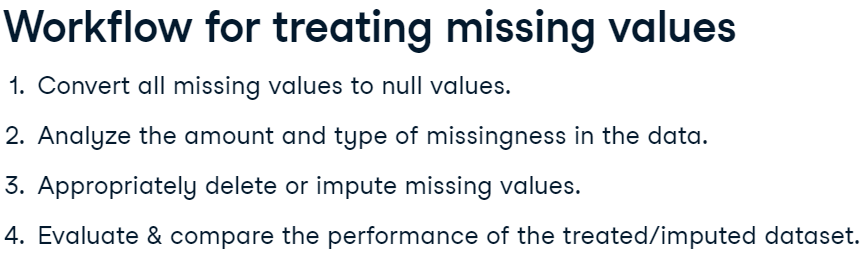

### Definicion de librerias

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
import seaborn as sns


In [2]:
# Imputacion y evaluacion
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from sklearn.preprocessing import OneHotEncoder

### Leer, borrar missing values y diagnosticar dataset, antes de la codificacion de los datos categoricos

In [4]:
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root # Importar el módulo root

file_path = root.DIR_DATA_STAGE + 'db_pross_info_users.csv'

In [5]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())
df.head()

(4173, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4173 entries, 0 to 4172
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PLAZO                     4173 non-null   int64  
 1   CAPITAL                   4173 non-null   int64  
 2   INT CORRIENTE             4173 non-null   float64
 3   PRÓXIMA FECHA PAGO        4173 non-null   object 
 4   DÍAS MORA                 4173 non-null   int64  
 5   Cuotas en mora            4173 non-null   int64  
 6   TIPO EMPLEO               4142 non-null   object 
 7   TIPO DE VIVIENDA          3384 non-null   object 
 8   ESTRATO                   4159 non-null   float64
 9   AÑOS EN LA VIVIENDA       4173 non-null   object 
 10  INGRESOS MENSUALES        3465 non-null   float64
 11  GASTOS MENSUALES          3445 non-null   float64
 12  INGRESOS ADICIONALES      2379 non-null   float64
 13  TIPO DE CONTRATO          3436 non-null   object 
 1

,PLAZO,CAPITAL,INT CORRIENTE,PRÓXIMA FECHA PAGO,DÍAS MORA,Cuotas en mora,TIPO EMPLEO,TIPO DE VIVIENDA,ESTRATO,AÑOS EN LA VIVIENDA,...,ESTADO CIVIL,NIVEL EDUCATIVO,PERSONAS A CARGO,NUMERO DE HIJOS,TIPO DE VEHICULO,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,latitud,longitud,meses_transcurridos
0,9,100000,563.100000,2015-06-27,2869,1,empleado,NaN,2.0,mas de 5 anos,...,NaN,NaN,0.0,0.0,ninguno,1,0,1.21361,-77.28111,24.0
1,14,150000,1313.900000,2015-07-02,2864,1,empleado,NaN,3.0,mas de 5 anos,...,NaN,NaN,0.0,0.0,ninguno,1,0,3.90089,-76.29783,12.0
2,30,350000,6569.500000,2015-07-10,2856,1,empleado,NaN,3.0,mas de 5 anos,...,NaN,NaN,0.0,0.0,carro,1,0,7.53941,-72.77238,12.0
3,29,250000,4536.083333,2015-07-15,2851,1,independiente,NaN,3.0,entre uno y cinco anos,...,NaN,NaN,1.0,1.0,ninguno,1,0,4.60971,-74.08175,NaN
4,28,200000,3503.733333,2015-07-15,2851,1,empleado,NaN,3.0,entre uno y cinco anos,...,NaN,NaN,1.0,1.0,ninguno,1,0,5.04333,-76.01667,0.0


In [6]:
# cantinad de datos nulos
df.isnull().mean()*100

PLAZO                        0.000000
CAPITAL                      0.000000
INT CORRIENTE                0.000000
PRÓXIMA FECHA PAGO           0.000000
DÍAS MORA                    0.000000
Cuotas en mora               0.000000
TIPO EMPLEO                  0.742871
TIPO DE VIVIENDA            18.907261
ESTRATO                      0.335490
AÑOS EN LA VIVIENDA          0.000000
INGRESOS MENSUALES          16.966211
GASTOS MENSUALES            17.445483
INGRESOS ADICIONALES        42.990654
TIPO DE CONTRATO            17.661155
PERIODO DE PAGO             17.780973
ESTADO CIVIL                19.051042
NIVEL EDUCATIVO             19.242751
PERSONAS A CARGO            33.117661
NUMERO DE HIJOS             33.213515
TIPO DE VEHICULO             0.455308
NUM.CREDITOS SOLICITADOS     0.000000
USUARIO RECURRENTE           0.000000
latitud                      0.000000
longitud                     0.000000
meses_transcurridos         25.377426
dtype: float64

In [7]:
cols_with_nan = [col for col in df.columns if df[col].isnull().any()]
cols_with_nan

['TIPO EMPLEO',
 'TIPO DE VIVIENDA',
 'ESTRATO',
 'INGRESOS MENSUALES',
 'GASTOS MENSUALES',
 'INGRESOS ADICIONALES',
 'TIPO DE CONTRATO',
 'PERIODO DE PAGO',
 'ESTADO CIVIL',
 'NIVEL EDUCATIVO',
 'PERSONAS A CARGO',
 'NUMERO DE HIJOS',
 'TIPO DE VEHICULO',
 'meses_transcurridos']

Se eliminan las columnas qu etengan mas de un 30% de datso faltantes

In [8]:
df.drop(['PERSONAS A CARGO','NUMERO DE HIJOS','INGRESOS ADICIONALES'], axis=1, inplace=True)

In [9]:
cols_with_nan = [col for col in df.columns if df[col].isnull().any()]
cols_with_nan

['TIPO EMPLEO',
 'TIPO DE VIVIENDA',
 'ESTRATO',
 'INGRESOS MENSUALES',
 'GASTOS MENSUALES',
 'TIPO DE CONTRATO',
 'PERIODO DE PAGO',
 'ESTADO CIVIL',
 'NIVEL EDUCATIVO',
 'TIPO DE VEHICULO',
 'meses_transcurridos']

### Graficas caracterizacion imputacion

<Axes: >

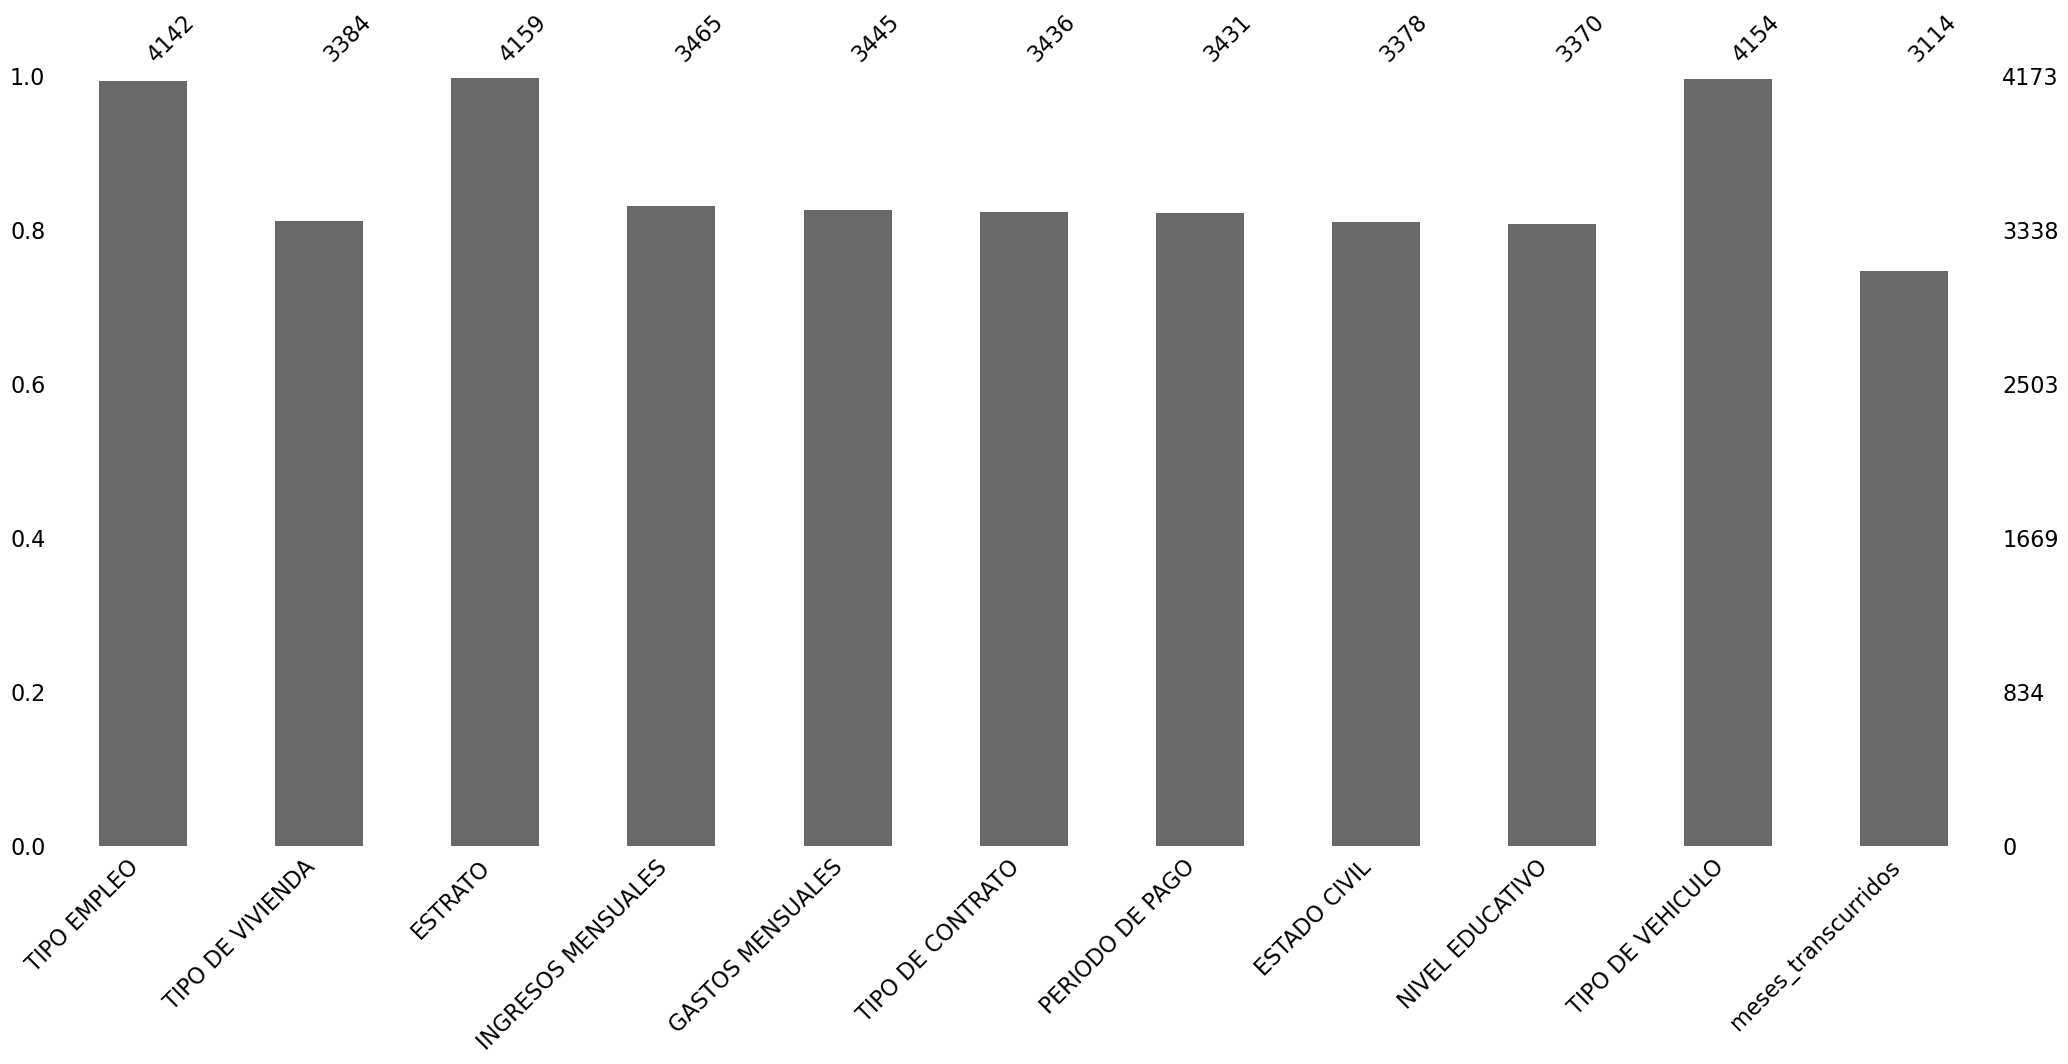

In [10]:
msno.bar(df[cols_with_nan])

<Axes: >

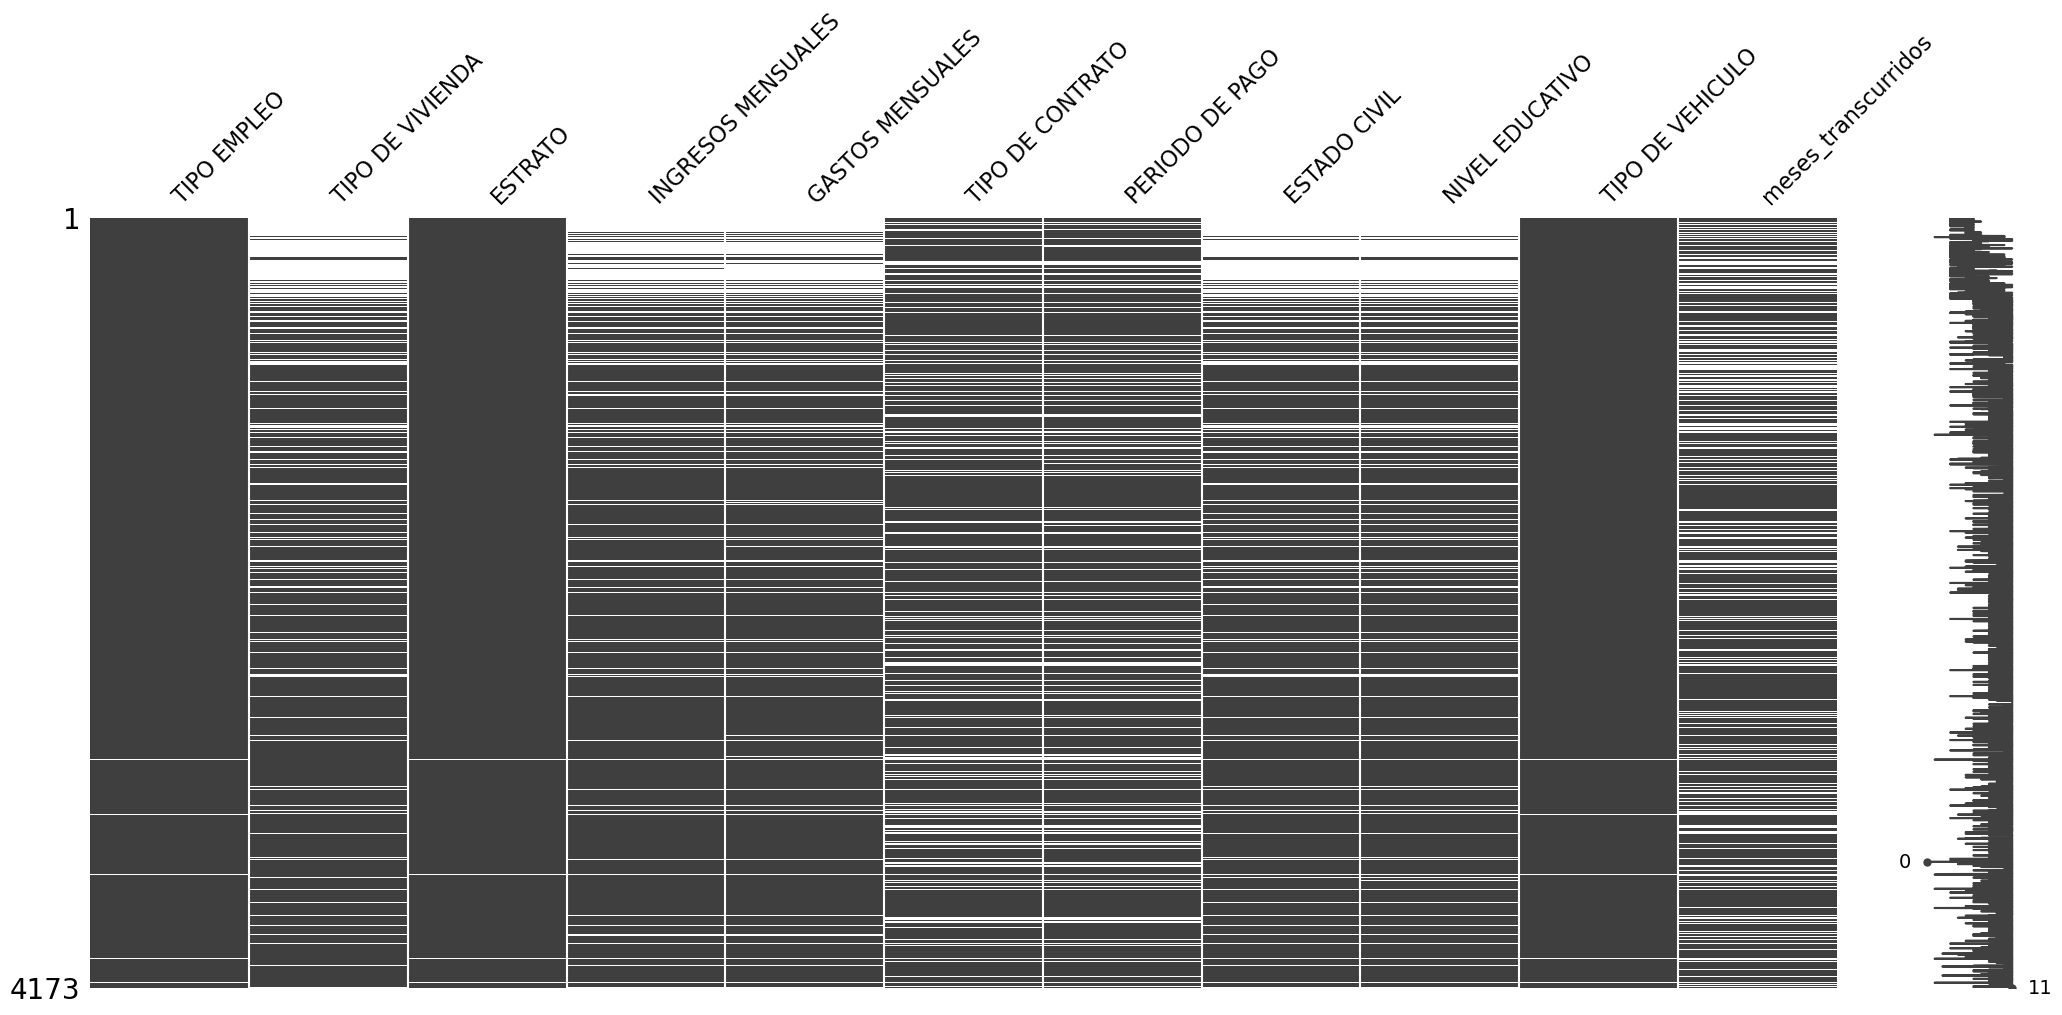

In [11]:
msno.matrix(df[cols_with_nan])

<Axes: >

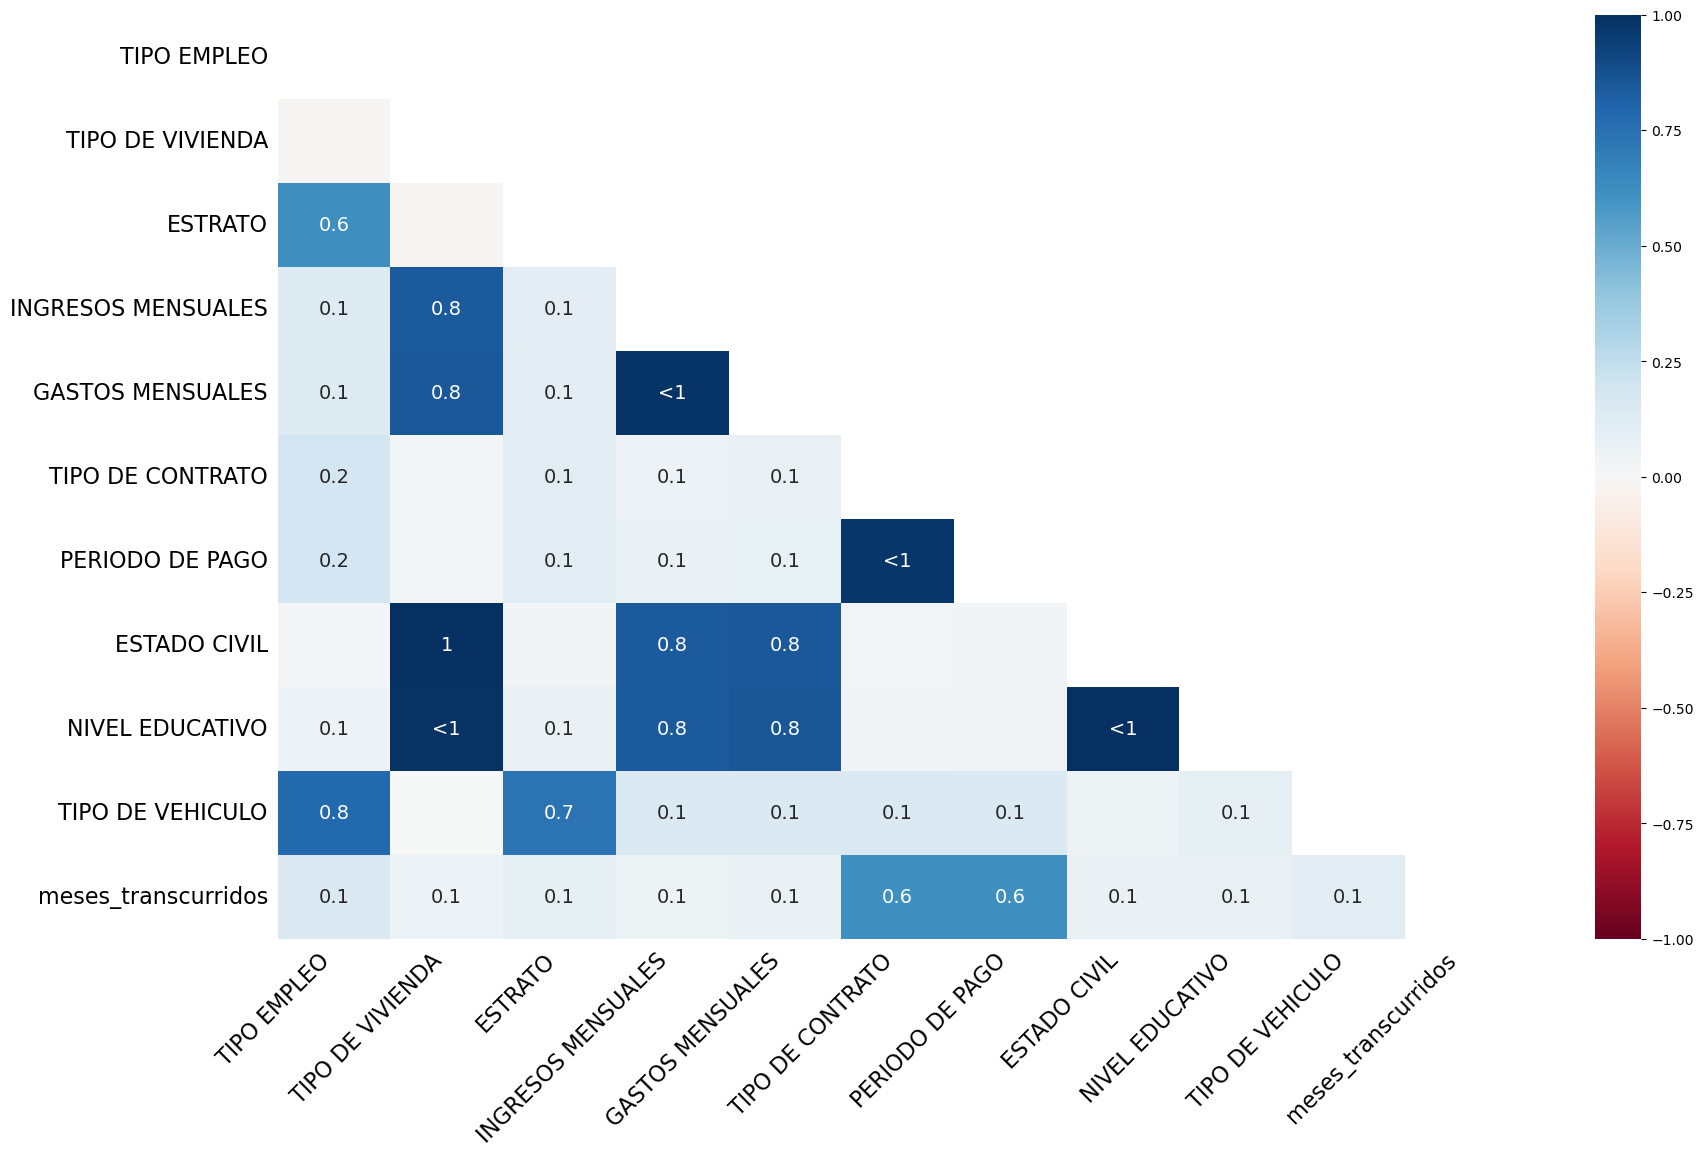

In [12]:
msno.heatmap(df[cols_with_nan])

<Axes: >

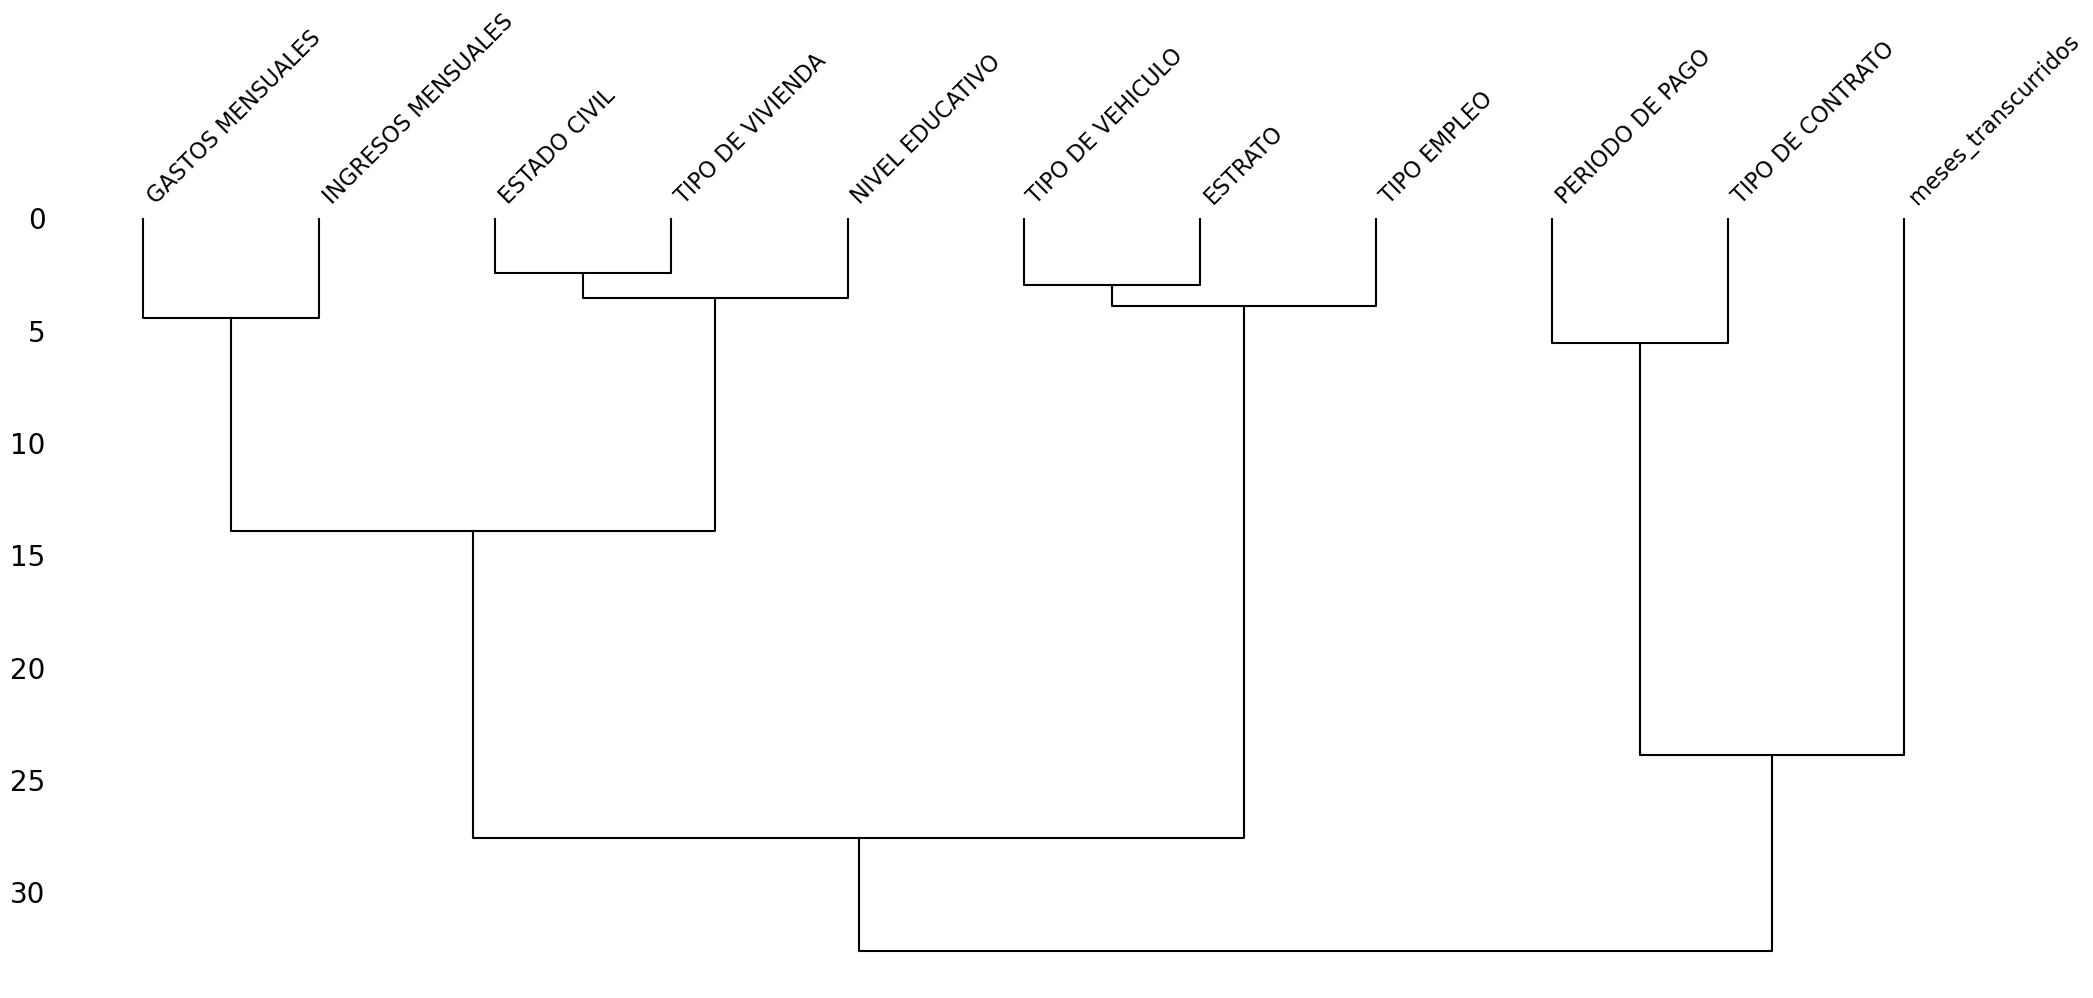

In [13]:
msno.dendrogram(df[cols_with_nan])

## Distribucion inicial del dataset



In [14]:
# Eliminacion de registros con datos faltantes

df_cc = df.dropna(how='any')
print(df.shape)
print(df_cc.shape)


(4173, 22)
(2417, 22)


## Imputaciones

In [15]:
num_cols_nan = [col for col in df[cols_with_nan].select_dtypes(exclude=['object'])]
cat_cols_nan = [col for col in df[cols_with_nan].select_dtypes(include=['object'])]

In [16]:
cols = ['ESTRATO']
num_cols_nan = [col for col in num_cols_nan if col not in cols]
num_cols_nan

['INGRESOS MENSUALES', 'GASTOS MENSUALES', 'meses_transcurridos']

In [17]:
cat_cols_nan.extend(cols)
cat_cols_nan

['TIPO EMPLEO',
 'TIPO DE VIVIENDA',
 'TIPO DE CONTRATO',
 'PERIODO DE PAGO',
 'ESTADO CIVIL',
 'NIVEL EDUCATIVO',
 'TIPO DE VEHICULO',
 'ESTRATO']

### Imputaciones categoricas univariable
Se imputan las columnas categoricas con el metodo most frecuent

In [18]:
imputer = SimpleImputer(strategy='most_frequent')

#imputa las columnas
df[cat_cols_nan] = imputer.fit_transform(df[cat_cols_nan])

#confirma valores nulos en columnas imputadas
print("Valores nulos en columnas imputadas:")
print(df[cat_cols_nan].isnull().sum())

#valor imputado
print("Valor imputado:")
print(imputer.statistics_)

Valores nulos en columnas imputadas:
TIPO EMPLEO         0
TIPO DE VIVIENDA    0
TIPO DE CONTRATO    0
PERIODO DE PAGO     0
ESTADO CIVIL        0
NIVEL EDUCATIVO     0
TIPO DE VEHICULO    0
ESTRATO             0
dtype: int64
Valor imputado:
['empleado' 'familiar' 'indefinido' 'quincenal' 'soltero/a' 'profesional'
 'ninguno' 3.0]


### Imputacion numericas

## Eliminar outliers

In [19]:
df['INGRESOS MENSUALES'] = df['INGRESOS MENSUALES']/1000000
df['GASTOS MENSUALES'] = df['GASTOS MENSUALES']/1000000
df['CAPITAL'] = df['CAPITAL']/1000000

In [20]:
df['INGRESOS MENSUALES'].dropna().head()

19    0.95
21    0.85
78    1.50
89    1.20
97    2.22
Name: INGRESOS MENSUALES, dtype: float64

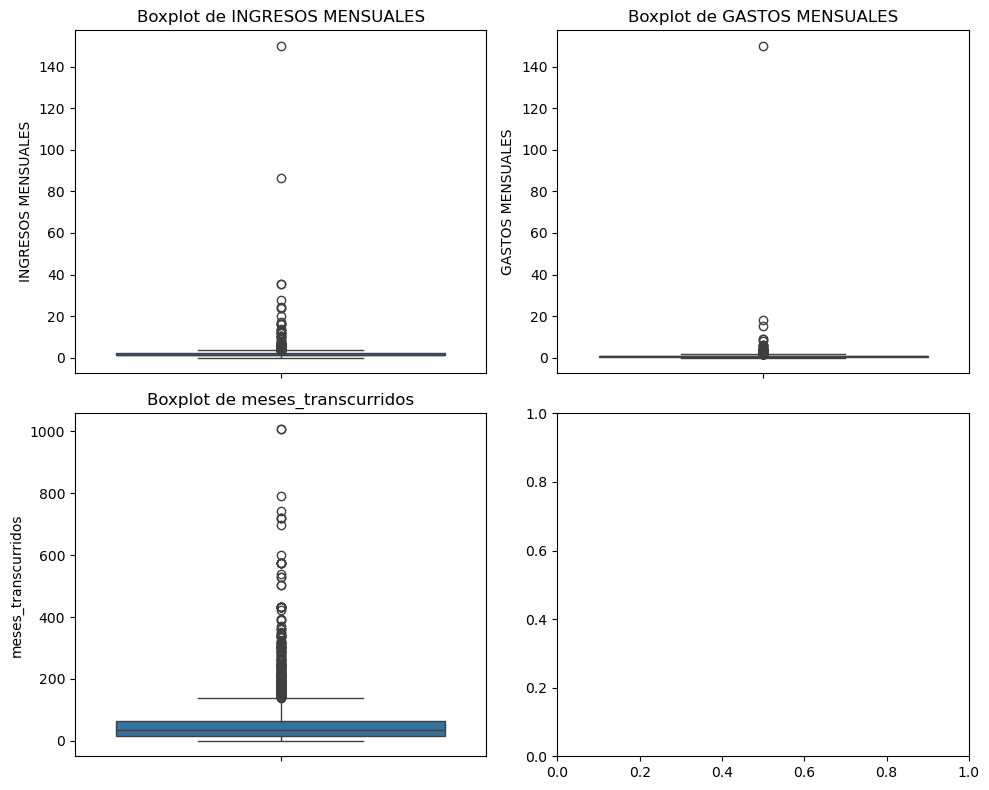

In [21]:
#boxplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Generar los boxplots para cada columna
for i, col in enumerate(num_cols_nan):
    row = i // 2
    col_idx = i % 2
    sns.boxplot(data=df.dropna(), y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

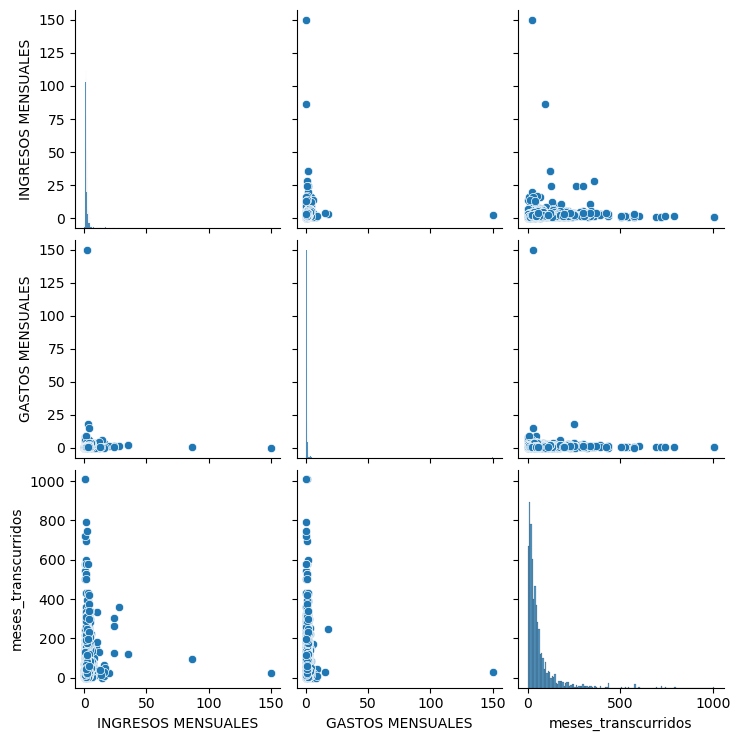

In [22]:
#scaterplots
sns.pairplot(df[num_cols_nan].dropna())

In [23]:
num_cols = [col for col in df.select_dtypes(exclude=['object'])]
cols = ['Cuotas en mora']
num_cols = [col for col in num_cols if col not in cols]
num_cols

['PLAZO',
 'CAPITAL',
 'INT CORRIENTE',
 'DÍAS MORA',
 'INGRESOS MENSUALES',
 'GASTOS MENSUALES',
 'NUM.CREDITOS SOLICITADOS',
 'USUARIO RECURRENTE',
 'latitud',
 'longitud',
 'meses_transcurridos']

In [25]:
df2 = df[num_cols].copy()
df2 = df2.apply(lambda col: col.fillna(col.median()), axis=0)
mu = df2.mean().values ### Calculando la media de los datos
Sigma_inv = np.linalg.inv(df2.cov().values) #### Calculando la inversa de la mtriz de covarianzas

centered = df2 - mu  ### Centrando los datos
centered = centered.to_numpy() ## par hacer multiplicacion de matrices es mejor llevar los dataframes a arrays

MD2 = np.matmul(np.matmul(centered, Sigma_inv),centered.transpose()) ### Usando la formula de la distancia de mahalanobis

MD2 = np.diag(MD2) ## Extrayendo la diagonal que mide la distancia al centroide de los puntos

from scipy.stats import chi2
alpha = 0.01
cut_off = chi2.ppf(1-alpha, len(df.columns)) ### Chi cuadrado con 1-alpha % y p grados de libertad
##### los grados de libertad p son la cantidad de variables es decir el largo de el vector de nombres de las columans


### Calculando el porcentaje de recorte con la metodologia de Mahal con significancia de alpha
print(f"Porcentaje de recorte: {round(100 * len(MD2[MD2 > cut_off])/len(df), 2)}%")

df2['MD2'] = MD2
df2["out"] = "0"
df2.loc[MD2 > cut_off, "out"] = "1"

Porcentaje de recorte: 2.71%


In [26]:
df2.nlargest(20, 'INGRESOS MENSUALES')

,PLAZO,CAPITAL,INT CORRIENTE,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,latitud,longitud,meses_transcurridos,MD2,out
1403,30,0.20,3754.0,1757,1358.000000,0.500,1,0,6.25184,-75.56359,31.291064,4021.675377,1
665,30,0.18,3378.6,2015,150.000000,0.250,1,0,4.60971,-74.08175,24.000000,49.889664,1
2392,30,0.20,3754.0,1356,125.000000,0.500,1,0,4.60971,-74.08175,31.291064,34.123389,0
1926,30,0.16,3003.2,1541,100.427500,0.001,1,0,4.60971,-74.08175,31.291064,22.826339,0
1333,30,0.15,2815.5,1793,86.578657,0.400,1,0,6.25184,-75.56359,94.218134,17.920262,0
4148,30,0.50,9385.0,455,35.500000,2.000,1,0,4.60971,-74.08175,120.137976,10.816035,0
4152,30,0.50,9385.0,453,35.500000,2.000,2,1,4.60971,-74.08175,120.203679,24.891012,0
454,30,0.40,7508.0,2154,35.000000,1.000,1,0,4.60971,-74.08175,31.291064,8.019966,0
1321,30,0.20,3754.0,1801,35.000000,0.400,1,0,7.53941,-72.77238,31.291064,7.252048,0
2870,30,0.50,9385.0,1156,30.000000,1.500,1,0,4.60971,-74.08175,31.291064,8.248719,0


In [27]:
outliers_idx = df2[df2["out"] == "1"].index
outliers_idx

Index([   0,   22,  112,  133,  134,  135,  145,  154,  167,  176,
       ...
       3720, 3880, 3885, 3896, 3903, 4008, 4019, 4075, 4119, 4162],
      dtype='int64', length=113)

In [28]:
df_clean = df.drop(outliers_idx)

In [29]:
df_clean[num_cols].nlargest(20, 'INGRESOS MENSUALES')

,PLAZO,CAPITAL,INT CORRIENTE,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,latitud,longitud,meses_transcurridos
2392,30,0.20,3754.0,1356,125.000000,0.500,1,0,4.60971,-74.08175,NaN
1926,30,0.16,3003.2,1541,100.427500,0.001,1,0,4.60971,-74.08175,NaN
1333,30,0.15,2815.5,1793,86.578657,0.400,1,0,6.25184,-75.56359,94.218134
4148,30,0.50,9385.0,455,35.500000,2.000,1,0,4.60971,-74.08175,120.137976
4152,30,0.50,9385.0,453,35.500000,2.000,2,1,4.60971,-74.08175,120.203679
454,30,0.40,7508.0,2154,35.000000,1.000,1,0,4.60971,-74.08175,NaN
1321,30,0.20,3754.0,1801,35.000000,0.400,1,0,7.53941,-72.77238,NaN
2870,30,0.50,9385.0,1156,30.000000,1.500,1,0,4.60971,-74.08175,NaN
1404,30,0.20,3754.0,1757,27.650000,1.100,1,0,8.23773,-73.35604,360.512484
1173,30,0.30,5631.0,1874,24.250000,1.500,1,0,6.17591,-75.59174,264.000000


In [30]:
df.shape , df_clean.shape

((4173, 22), (4060, 22))

In [31]:
def clean_univariate_sample(df, column_name):
    # Extraer la columna del DataFrame
    x = df[column_name].dropna()  # Remover NaN para evitar problemas en el cálculo de percentiles

    # Calcular los percentiles y el rango intercuartílico
    Q1, Q3 = np.percentile(x, [25, 75])
    IQR = Q3 - Q1

    # Calcular los límites para identificar valores atípicos
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # Filtrar y actualizar el DataFrame original sin outliers
    df[column_name] = df[column_name].apply(lambda y: lim_inf if y <= lim_inf else y)
    df[column_name] = df[column_name].apply(lambda y: lim_sup if y >= lim_sup else y)

    return df
    

In [32]:
df_clean2 = df_clean.copy()

In [33]:
df_clean2 = clean_univariate_sample(df_clean2, 'INGRESOS MENSUALES')
df_clean2 = clean_univariate_sample(df_clean2, 'meses_transcurridos')
df_clean2 = clean_univariate_sample(df_clean2, 'GASTOS MENSUALES')

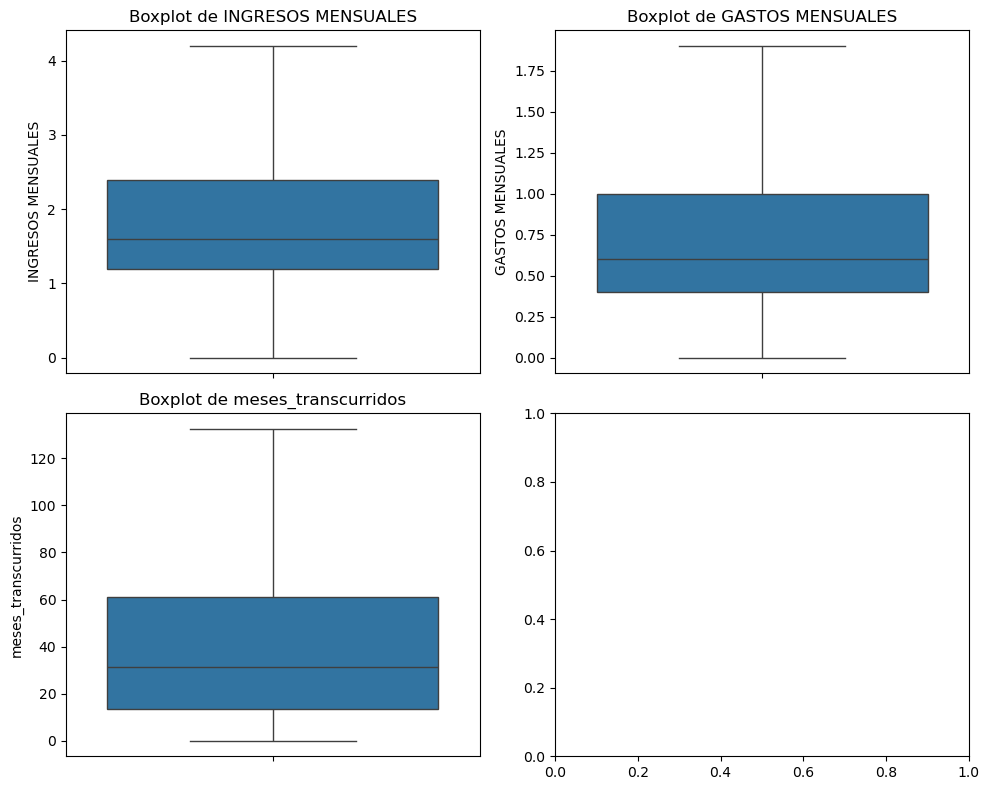

In [34]:
#boxplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Generar los boxplots para cada columna
for i, col in enumerate(num_cols_nan):
    row = i // 2
    col_idx = i % 2
    sns.boxplot(data=df_clean2, y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

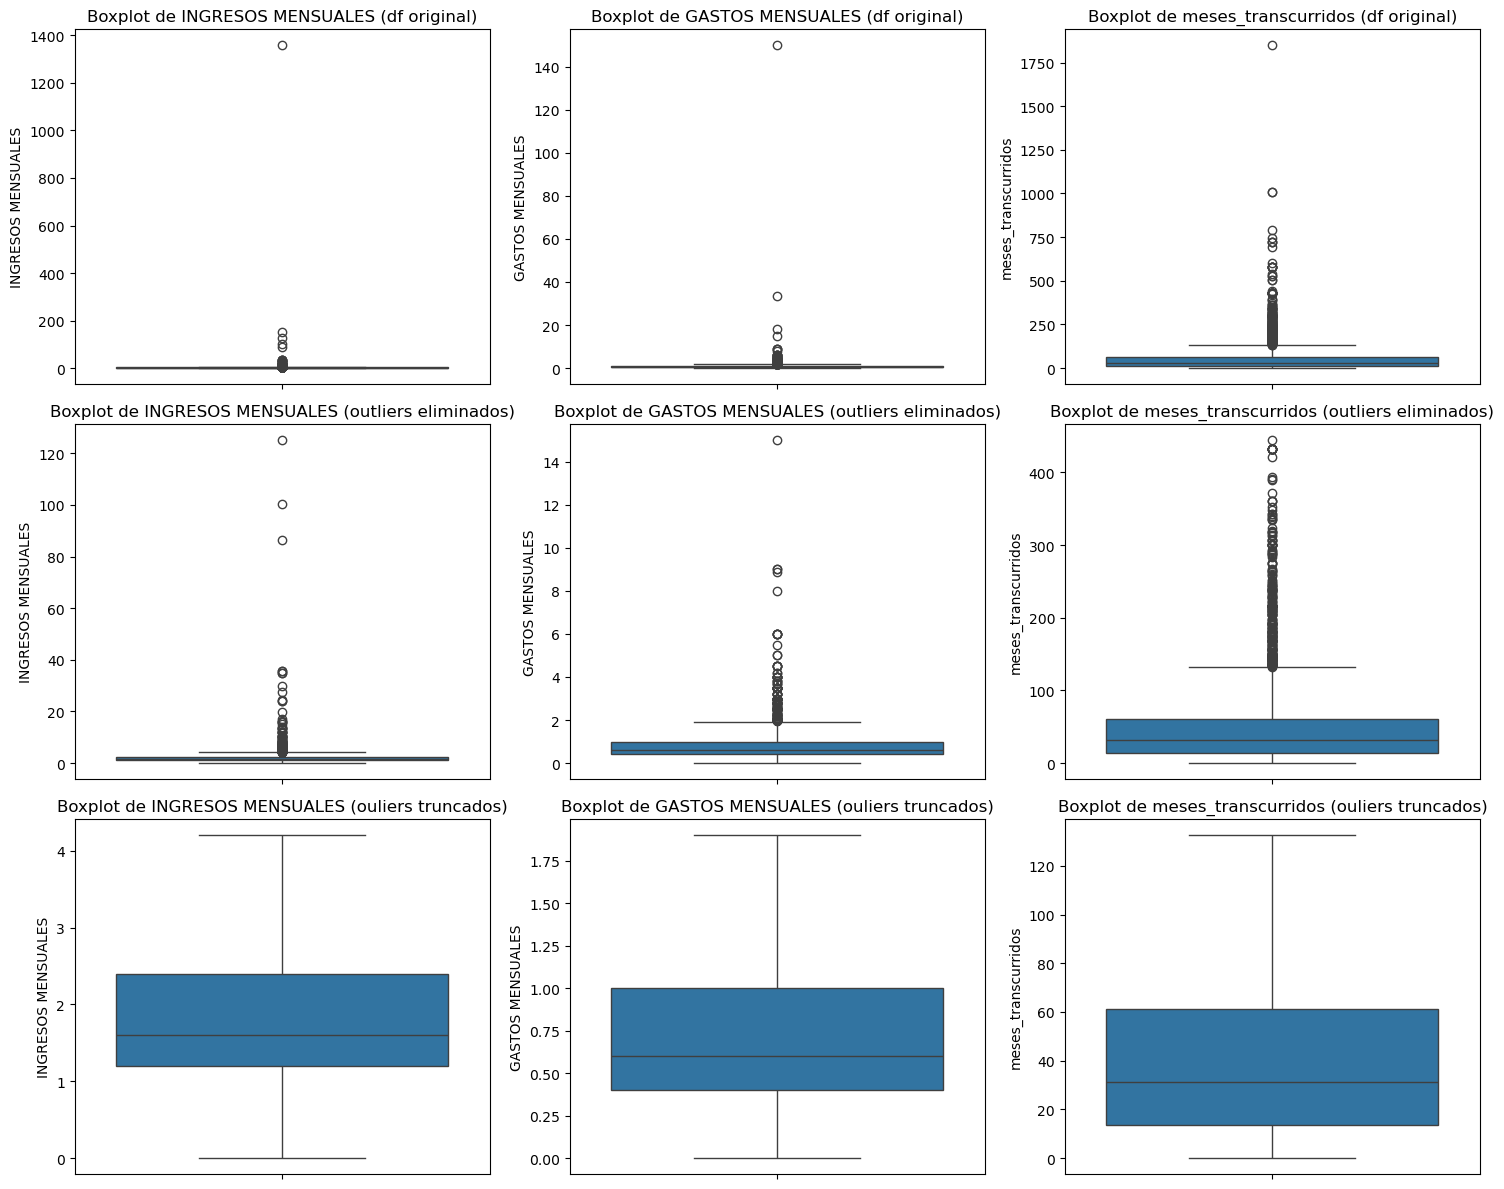

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Generar los boxplots para cada columna en df1
for i, col in enumerate(num_cols_nan):
    sns.boxplot(data=df, y=col, ax=axes[0, i])
    axes[0, i].set_title(f'Boxplot de {col} (df original)')

# Generar los boxplots para cada columna en df2
for i, col in enumerate(num_cols_nan):
    sns.boxplot(data=df_clean, y=col, ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot de {col} (outliers eliminados)')

# Generar los boxplots para cada columna en df3
for i, col in enumerate(num_cols_nan):
    sns.boxplot(data=df_clean2, y=col, ax=axes[2, i])
    axes[2, i].set_title(f'Boxplot de {col} (ouliers truncados)')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

## Revisar distribuciones

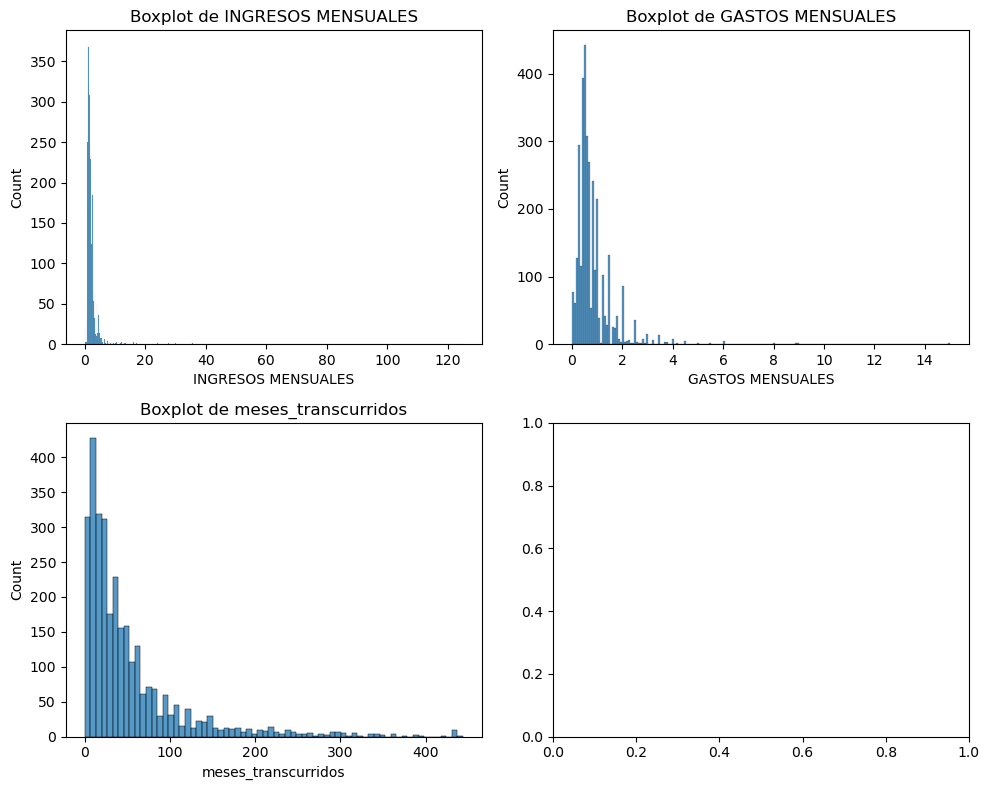

In [36]:
#histplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Generar los boxplots para cada columna
for i, col in enumerate(num_cols_nan):
    row = i // 2
    col_idx = i % 2
    sns.histplot(data=df_clean, x=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

## Imputacion con regresion para datos numericos

In [37]:
num_cols

['PLAZO',
 'CAPITAL',
 'INT CORRIENTE',
 'DÍAS MORA',
 'INGRESOS MENSUALES',
 'GASTOS MENSUALES',
 'NUM.CREDITOS SOLICITADOS',
 'USUARIO RECURRENTE',
 'latitud',
 'longitud',
 'meses_transcurridos']

In [38]:
imputer = SimpleImputer(strategy='median')
cols_to_impute = ['GASTOS MENSUALES','meses_transcurridos']

#imputa las columnas
df_clean[cols_to_impute] = imputer.fit_transform(df_clean[cols_to_impute])

#confirma valores nulos en columnas imputadas
print("Valores nulos en columnas imputadas:")
print(df[cat_cols_nan].isnull().sum())

#valor imputado
print("Valor imputado:")
print(imputer.statistics_)

Valores nulos en columnas imputadas:
TIPO EMPLEO         0
TIPO DE VIVIENDA    0
TIPO DE CONTRATO    0
PERIODO DE PAGO     0
ESTADO CIVIL        0
NIVEL EDUCATIVO     0
TIPO DE VEHICULO    0
ESTRATO             0
dtype: int64
Valor imputado:
[ 0.6        31.19250986]


In [39]:
X = df_clean.reset_index(drop=True)
X_num = X[num_cols]
X_cat = X.drop(num_cols, axis=1)

In [40]:
# Crear el LinearRegression
linear_regressor = LinearRegression()

# Configurar el IterativeImputer con regresión lineal
iterative_imputer_lr = IterativeImputer(estimator=linear_regressor, max_iter=10, random_state=0)
X_imputed = iterative_imputer_lr.fit_transform(X_num)
X_imputed = pd.DataFrame(X_imputed, columns=num_cols)

In [41]:
df_imputed = pd.concat([X_imputed, X_cat], axis=1)

In [42]:
df_clean.shape, df_imputed.shape

((4060, 22), (4060, 22))

<Axes: >

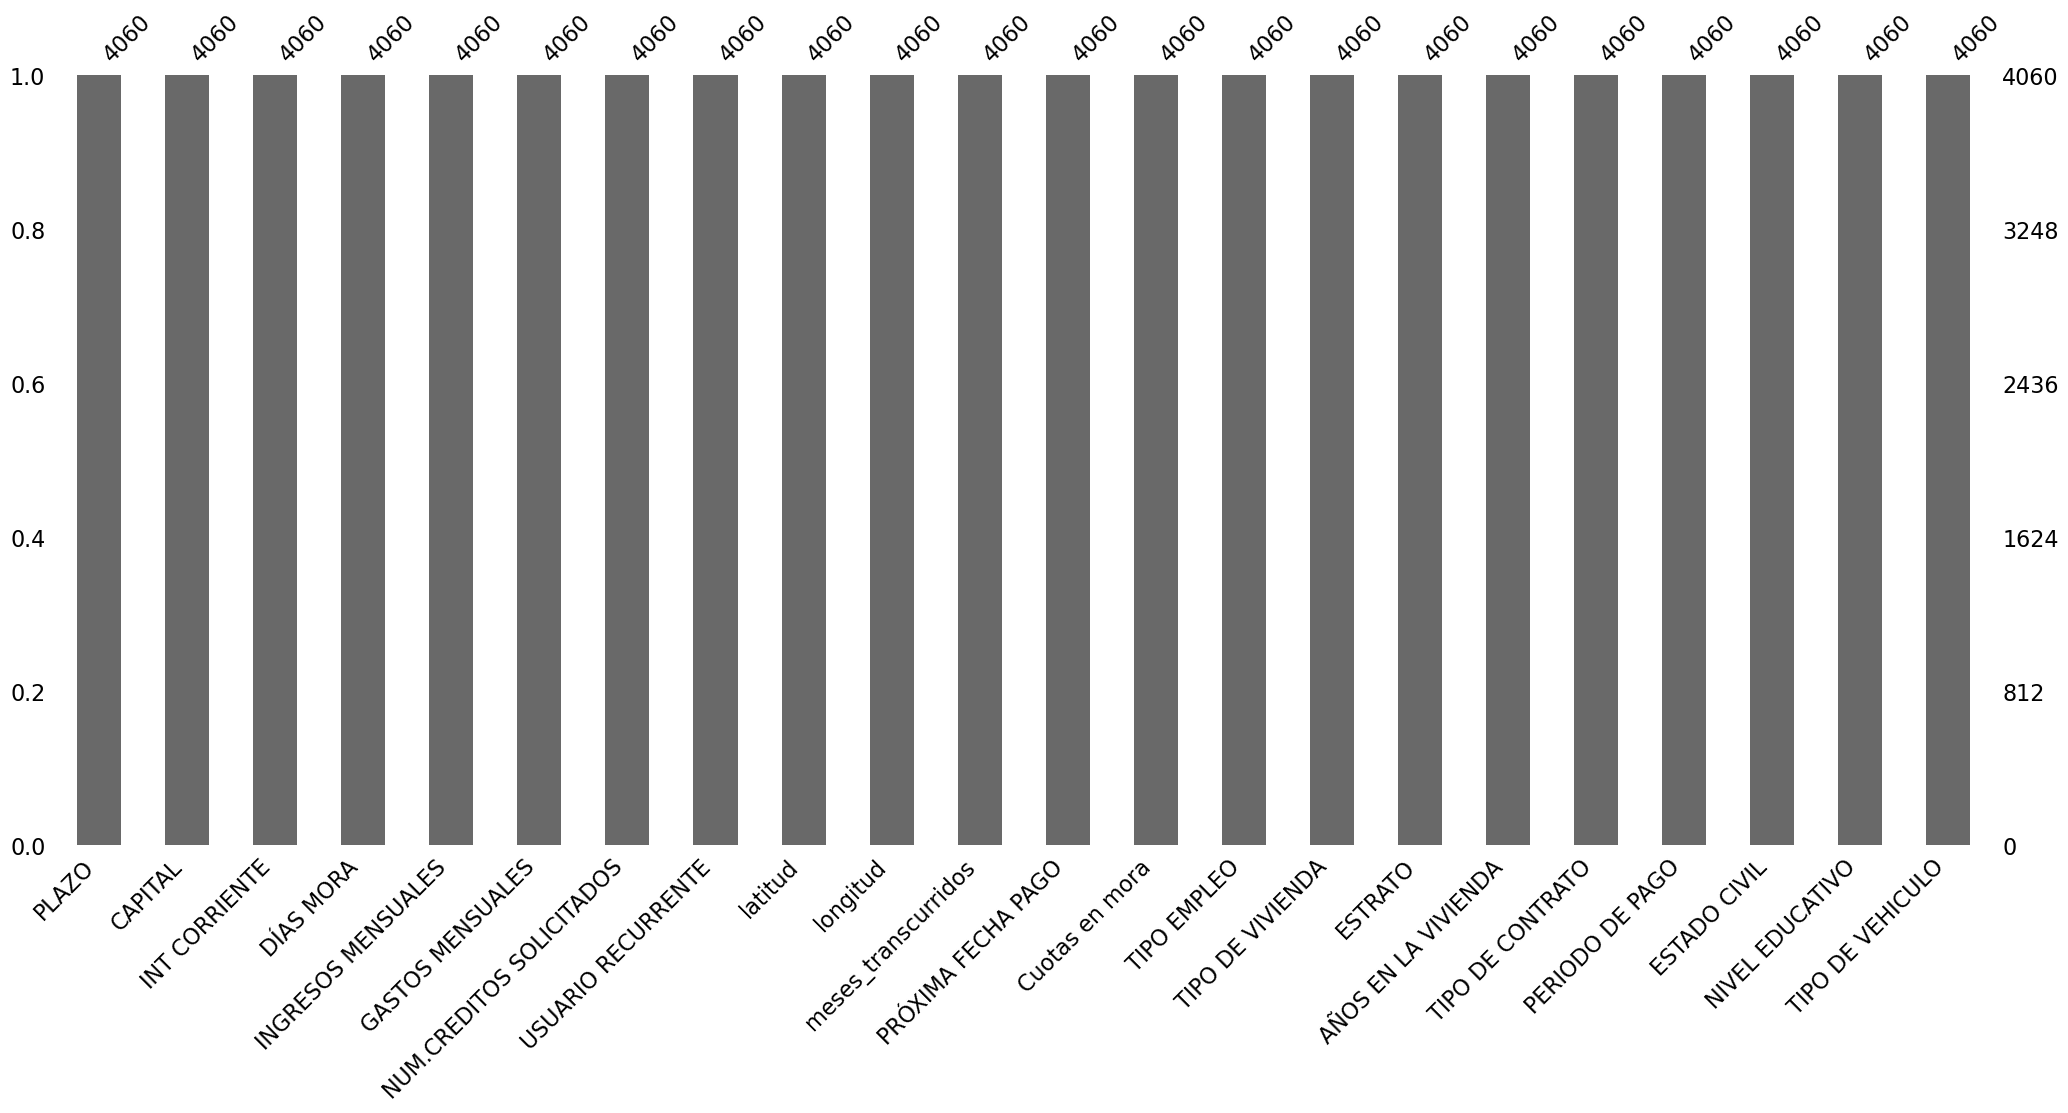

In [43]:
msno.bar(df_imputed)

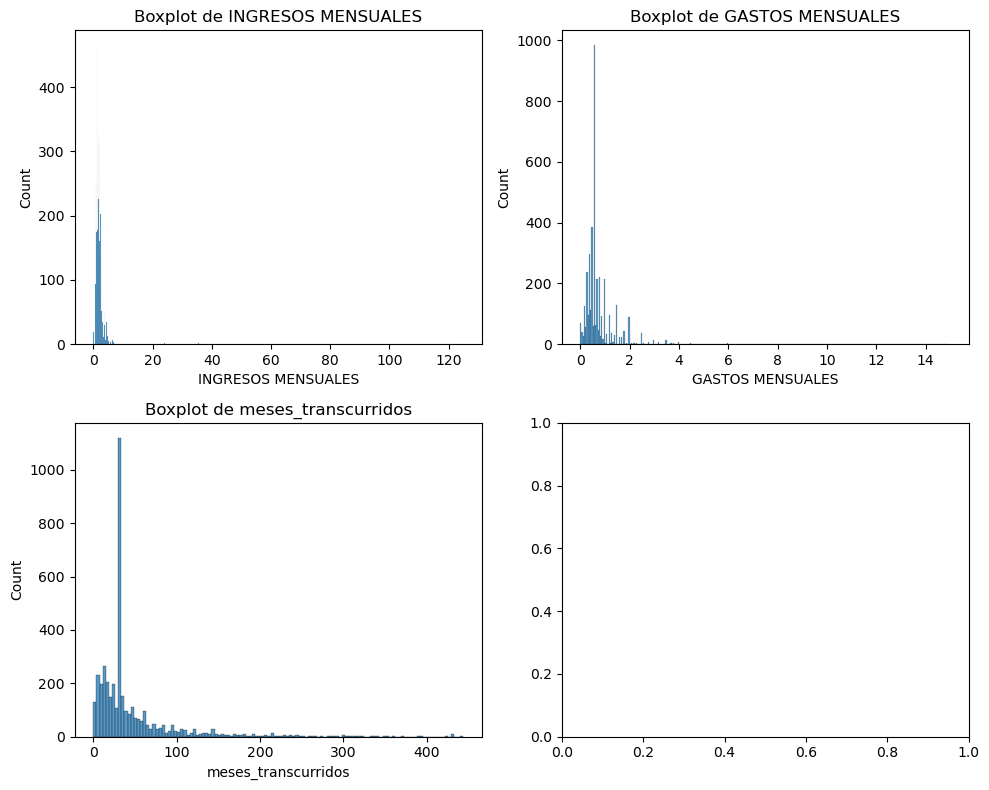

In [44]:
#histplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Generar los boxplots para cada columna
for i, col in enumerate(num_cols_nan):
    row = i // 2
    col_idx = i % 2
    sns.histplot(data=df_imputed, x=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

## Codificacion

In [45]:
### Codificacion fecha desembolso a meses
df_imputed['PRÓXIMA FECHA PAGO'] = pd.to_datetime(df_imputed['PRÓXIMA FECHA PAGO'], errors='coerce', format='%Y-%m-%d')
df_imputed['mes_de_pago'] = df_imputed['PRÓXIMA FECHA PAGO'].dt.month


In [46]:
df_imputed[['PRÓXIMA FECHA PAGO','mes_de_pago']].head()


,PRÓXIMA FECHA PAGO,mes_de_pago
0,2015-07-02,7
1,2015-07-10,7
2,2015-07-15,7
3,2015-07-15,7
4,2015-07-16,7


In [47]:
df_imputed.drop(columns=['PRÓXIMA FECHA PAGO'], inplace=True)

### Codificacion variables categoricas

In [48]:
df.dtypes

PLAZO                         int64
CAPITAL                     float64
INT CORRIENTE               float64
PRÓXIMA FECHA PAGO           object
DÍAS MORA                     int64
Cuotas en mora                int64
TIPO EMPLEO                  object
TIPO DE VIVIENDA             object
ESTRATO                      object
AÑOS EN LA VIVIENDA          object
INGRESOS MENSUALES          float64
GASTOS MENSUALES            float64
TIPO DE CONTRATO             object
PERIODO DE PAGO              object
ESTADO CIVIL                 object
NIVEL EDUCATIVO              object
TIPO DE VEHICULO             object
NUM.CREDITOS SOLICITADOS      int64
USUARIO RECURRENTE            int64
latitud                     float64
longitud                    float64
meses_transcurridos         float64
dtype: object

In [49]:
cat_cols = [col for col in df.select_dtypes(include=['object'])]
cat_cols.remove('PRÓXIMA FECHA PAGO')
cat_cols.remove('ESTRATO')

cat_cols


['TIPO EMPLEO',
 'TIPO DE VIVIENDA',
 'AÑOS EN LA VIVIENDA',
 'TIPO DE CONTRATO',
 'PERIODO DE PAGO',
 'ESTADO CIVIL',
 'NIVEL EDUCATIVO',
 'TIPO DE VEHICULO']

In [50]:
unique_counts = {col: df[col].nunique() for col in cat_cols}
unique_counts

{'TIPO EMPLEO': 5,
 'TIPO DE VIVIENDA': 3,
 'AÑOS EN LA VIVIENDA': 3,
 'TIPO DE CONTRATO': 3,
 'PERIODO DE PAGO': 2,
 'ESTADO CIVIL': 6,
 'NIVEL EDUCATIVO': 7,
 'TIPO DE VEHICULO': 3}

In [51]:
df_imputed['NIVEL EDUCATIVO'].unique()

array(['profesional', 'tecnico', 'no tengo', 'tecnologo', 'secundaria',
       'postgrado', 'primaria'], dtype=object)

In [52]:
df_encoded = pd.get_dummies(df_imputed, columns=cat_cols, drop_first=True,dtype=float)

In [53]:
df_encoded.head()

,PLAZO,CAPITAL,INT CORRIENTE,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,latitud,longitud,...,ESTADO CIVIL_union libre,ESTADO CIVIL_viudo/a,NIVEL EDUCATIVO_postgrado,NIVEL EDUCATIVO_primaria,NIVEL EDUCATIVO_profesional,NIVEL EDUCATIVO_secundaria,NIVEL EDUCATIVO_tecnico,NIVEL EDUCATIVO_tecnologo,TIPO DE VEHICULO_moto,TIPO DE VEHICULO_ninguno
0,14.0,0.15,1313.900000,2864.0,1.322643,0.6,1.0,0.0,3.90089,-76.29783,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,30.0,0.35,6569.500000,2856.0,2.236870,0.6,1.0,0.0,7.53941,-72.77238,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,29.0,0.25,4536.083333,2851.0,1.956385,0.6,1.0,0.0,4.60971,-74.08175,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,28.0,0.20,3503.733333,2851.0,1.491783,0.6,1.0,0.0,5.04333,-76.01667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,30.0,0.15,2815.500000,2850.0,2.000175,0.6,1.0,0.0,7.53941,-72.77238,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df_imputed.shape,df_encoded.shape

((4060, 22), (4060, 38))

In [55]:
df_encoded.isnull().sum()

PLAZO                                       0
CAPITAL                                     0
INT CORRIENTE                               0
DÍAS MORA                                   0
INGRESOS MENSUALES                          0
GASTOS MENSUALES                            0
NUM.CREDITOS SOLICITADOS                    0
USUARIO RECURRENTE                          0
latitud                                     0
longitud                                    0
meses_transcurridos                         0
Cuotas en mora                              0
ESTRATO                                     0
mes_de_pago                                 0
TIPO EMPLEO_empleado                        0
TIPO EMPLEO_independiente                   0
TIPO EMPLEO_pensionado                      0
TIPO EMPLEO_prestador de servicios          0
TIPO DE VIVIENDA_familiar                   0
TIPO DE VIVIENDA_propia                     0
AÑOS EN LA VIVIENDA_mas de 5 anos           0
AÑOS EN LA VIVIENDA_menos de un an

## Generacion de dataset final imputado y codificado

In [56]:
df_encoded.columns

Index(['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'DÍAS MORA', 'INGRESOS MENSUALES',
       'GASTOS MENSUALES', 'NUM.CREDITOS SOLICITADOS', 'USUARIO RECURRENTE',
       'latitud', 'longitud', 'meses_transcurridos', 'Cuotas en mora',
       'ESTRATO', 'mes_de_pago', 'TIPO EMPLEO_empleado',
       'TIPO EMPLEO_independiente', 'TIPO EMPLEO_pensionado',
       'TIPO EMPLEO_prestador de servicios', 'TIPO DE VIVIENDA_familiar',
       'TIPO DE VIVIENDA_propia', 'AÑOS EN LA VIVIENDA_mas de 5 anos',
       'AÑOS EN LA VIVIENDA_menos de un ano',
       'TIPO DE CONTRATO_prestacion de servicios',
       'TIPO DE CONTRATO_termino fijo', 'PERIODO DE PAGO_quincenal',
       'ESTADO CIVIL_comprometido/a', 'ESTADO CIVIL_divorciado/a',
       'ESTADO CIVIL_soltero/a', 'ESTADO CIVIL_union libre',
       'ESTADO CIVIL_viudo/a', 'NIVEL EDUCATIVO_postgrado',
       'NIVEL EDUCATIVO_primaria', 'NIVEL EDUCATIVO_profesional',
       'NIVEL EDUCATIVO_secundaria', 'NIVEL EDUCATIVO_tecnico',
       'NIVEL EDUCATIVO_t

In [57]:

file_path = root.DIR_DATA_STAGE + 'df_imputado.csv'
df_encoded.to_csv(file_path, index=False)


In [58]:
df_encoded.shape

(4060, 38)

In [59]:
df_encoded.dtypes

PLAZO                                       float64
CAPITAL                                     float64
INT CORRIENTE                               float64
DÍAS MORA                                   float64
INGRESOS MENSUALES                          float64
GASTOS MENSUALES                            float64
NUM.CREDITOS SOLICITADOS                    float64
USUARIO RECURRENTE                          float64
latitud                                     float64
longitud                                    float64
meses_transcurridos                         float64
Cuotas en mora                                int64
ESTRATO                                      object
mes_de_pago                                   int32
TIPO EMPLEO_empleado                        float64
TIPO EMPLEO_independiente                   float64
TIPO EMPLEO_pensionado                      float64
TIPO EMPLEO_prestador de servicios          float64
TIPO DE VIVIENDA_familiar                   float64
TIPO DE VIVI

In [60]:
df_encoded['ESTRATO'].head()

0    3.0
1    3.0
2    3.0
3    3.0
4    3.0
Name: ESTRATO, dtype: object

In [61]:
df_encoded.isnull().sum()

PLAZO                                       0
CAPITAL                                     0
INT CORRIENTE                               0
DÍAS MORA                                   0
INGRESOS MENSUALES                          0
GASTOS MENSUALES                            0
NUM.CREDITOS SOLICITADOS                    0
USUARIO RECURRENTE                          0
latitud                                     0
longitud                                    0
meses_transcurridos                         0
Cuotas en mora                              0
ESTRATO                                     0
mes_de_pago                                 0
TIPO EMPLEO_empleado                        0
TIPO EMPLEO_independiente                   0
TIPO EMPLEO_pensionado                      0
TIPO EMPLEO_prestador de servicios          0
TIPO DE VIVIENDA_familiar                   0
TIPO DE VIVIENDA_propia                     0
AÑOS EN LA VIVIENDA_mas de 5 anos           0
AÑOS EN LA VIVIENDA_menos de un an